# Randomized Image Sampling for Explanations (RISE)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from ultralytics import YOLO

from utils import *
from explanations import RISE, get_confidence_vector_from_ultralytics_result_objects

cudnn.benchmark = True

In [2]:
args = Dummy()

# Number of workers to load data
args.workers = 8
# Directory with images split into class folders.
# Since we don't use ground truth labels for saliency all images can be 
# moved to one class folder.
args.datadir = '/home/edgar-acer/image_net_data'
# Sets the range of images to be explained for dataloader.
args.range = range(95, 105)
# Size of imput images.
args.input_size = (512, 512)
# Size of batches for GPU. 
# Use maximum number that the GPU allows.
args.gpu_batch = 8

## Load black-box model

In [3]:
# Load black box model for explanations
# model = models.resnet18(True)
# model = nn.Sequential(model, nn.Softmax(dim=1))
# model = model.eval()
# model = model.cuda()
model = YOLO('/home/edgar-acer/images/best.pt')

# for p in model.parameters():
#     p.requires_grad = False


## Create explainer instance

In [4]:
explainer = RISE(model, args.input_size, args.gpu_batch)

In [5]:
# Generate masks for RISE or use the saved ones.
maskspath = 'masks_yolo.npy'
generate_new = False

if generate_new or not os.path.isfile(maskspath):
    explainer.generate_masks(N=1000, s=8, p1=0.1, savepath=maskspath)
else:
    explainer.load_masks(maskspath)
    print('Masks are loaded.')

Masks are loaded.


## Explaining one instance
Producing saliency maps for top $k$ predicted classes.

In [12]:
def example(img, index_class: int, class_name: str):
    saliency = explainer(img.cuda()).cpu().numpy()
    
    result = model(img.cuda())
    rslt_tensor = get_confidence_vector_from_ultralytics_result_objects([result])
    conf = float(rslt_tensor[0][index_class])
    
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title('{:.2f}% {}'.format(100*conf, class_name))
    tensor_imshow(img[0])

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title(class_name)
    tensor_imshow(img[0])
    sal = saliency[index_class]
    plt.imshow(sal, cmap='jet', alpha=0.5)
    plt.colorbar(fraction=0.046, pad=0.04)

    plt.show()
    
    

In [7]:
read_tensor_yolo = transforms.Compose([
    lambda x: Image.open(x),
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    lambda x: torch.unsqueeze(x, 0)
])

In [8]:
img = read_tensor_yolo('/home/edgar-acer/images/Hereford-1474.00MHz-122.88MHz/0.000e+00_2.134e-03.png')
result = model(img.cuda())
rslt_tensor = get_confidence_vector_from_ultralytics_result_objects([result])
conf = float(rslt_tensor[0][1])
print(f"{rslt_tensor=}, {conf=}")
explainer.p1 = 0.1


0: 512x512 1 lte, 4.0ms
Speed: 0.1ms preprocess, 4.0ms inference, 237.1ms postprocess per image at shape (1, 3, 512, 512)
rslt_tensor=tensor([[0.0000, 0.9121, 0.0000]], device='cuda:0'), conf=0.9121480584144592



0: 512x512 (no detections), 2.1ms
1: 512x512 (no detections), 2.1ms
2: 512x512 1 lte, 2.1ms
3: 512x512 (no detections), 2.1ms
4: 512x512 1 lte, 2.1ms
5: 512x512 1 lte, 2.1ms
6: 512x512 (no detections), 2.1ms
7: 512x512 1 gsm, 2.1ms
Speed: 0.0ms preprocess, 2.1ms inference, 2.6ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 2.0ms
1: 512x512 (no detections), 2.0ms
2: 512x512 (no detections), 2.0ms
3: 512x512 (no detections), 2.0ms
4: 512x512 (no detections), 2.0ms
5: 512x512 (no detections), 2.0ms
6: 512x512 (no detections), 2.0ms
7: 512x512 (no detections), 2.0ms
Speed: 0.0ms preprocess, 2.0ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 512)

0: 512x512 (no detections), 1.8ms
1: 512x512 1 lte, 1.8ms
2: 512x512 1 umts, 1.8ms
3: 512x512 1 gsm, 1.8ms
4: 512x512 (no detections), 1.8ms
5: 512x512 (no detections), 1.8ms
6: 512x512 (no detections), 1.8ms
7: 512x512 (no detections), 1.8ms
Speed: 0.0ms preprocess, 1.8ms inference, 0.7ms postproces

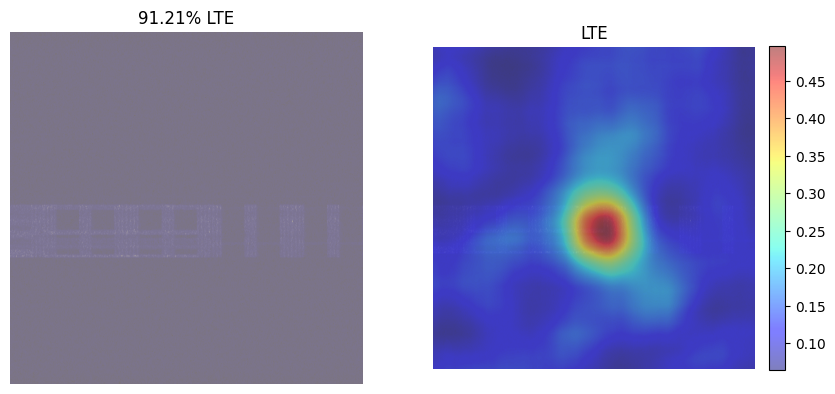

In [13]:
example(read_tensor_yolo('/home/edgar-acer/images/Hereford-1474.00MHz-122.88MHz/0.000e+00_2.134e-03.png'), 1, 'LTE')